In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Read datasets

In [2]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

# Data cleaning and preparation

In [5]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,title,text,subject,date,target
0,YOU’VE BEEN “TRUMPED”: Trump’s Response To Pre...,You know what they say about playing with fire...,politics,"Sep 11, 2015",fake
1,Senate repeals Labor Dept. municipal retiremen...,WASHINGTON (Reuters) - A divided U.S. Senate o...,politicsNews,"March 30, 2017",true
2,Investigators ask White House for details on F...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"September 20, 2017",true
3,South Sudan opposition groups meet in Kenya to...,KAMPALA (Reuters) - South Sudanese opposition ...,worldnews,"October 16, 2017",true
4,Obama warns Democrats against overconfidence a...,"CHILMARK, Mass. (Reuters) - Declaring he was t...",politicsNews,"August 16, 2016",true


In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,YOU’VE BEEN “TRUMPED”: Trump’s Response To Pre...,You know what they say about playing with fire...,politics,fake
1,Senate repeals Labor Dept. municipal retiremen...,WASHINGTON (Reuters) - A divided U.S. Senate o...,politicsNews,true
2,Investigators ask White House for details on F...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,true
3,South Sudan opposition groups meet in Kenya to...,KAMPALA (Reuters) - South Sudanese opposition ...,worldnews,true
4,Obama warns Democrats against overconfidence a...,"CHILMARK, Mass. (Reuters) - Declaring he was t...",politicsNews,true


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,You know what they say about playing with fire...,politics,fake
1,WASHINGTON (Reuters) - A divided U.S. Senate o...,politicsNews,true
2,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,true
3,KAMPALA (Reuters) - South Sudanese opposition ...,worldnews,true
4,"CHILMARK, Mass. (Reuters) - Declaring he was t...",politicsNews,true


In [11]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,you know what they say about playing with fire...,politics,fake
1,washington (reuters) - a divided u.s. senate o...,politicsNews,true
2,washington (reuters) - the special counsel inv...,politicsNews,true
3,kampala (reuters) - south sudanese opposition ...,worldnews,true
4,"chilmark, mass. (reuters) - declaring he was t...",politicsNews,true


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
data.head()

,text,subject,target
0,you know what they say about playing with fire...,politics,fake
1,washington reuters a divided us senate on thu...,politicsNews,true
2,washington reuters the special counsel invest...,politicsNews,true
3,kampala reuters south sudanese opposition gro...,worldnews,true
4,chilmark mass reuters declaring he was tired ...,politicsNews,true


In [14]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/abdullah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
data.head()

,text,subject,target
0,know say playing fire jindal comments trumpher...,politics,fake
1,washington reuters divided us senate thursday ...,politicsNews,true
2,washington reuters special counsel investigati...,politicsNews,true
3,kampala reuters south sudanese opposition grou...,worldnews,true
4,chilmark mass reuters declaring tired talking ...,politicsNews,true


# Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


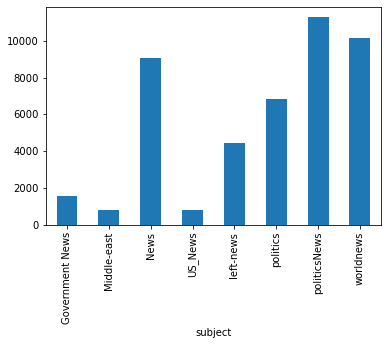

In [16]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


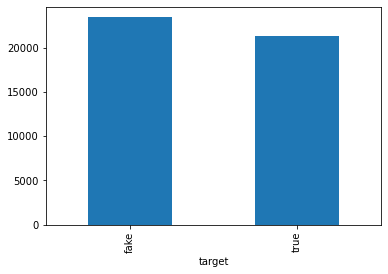

In [17]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

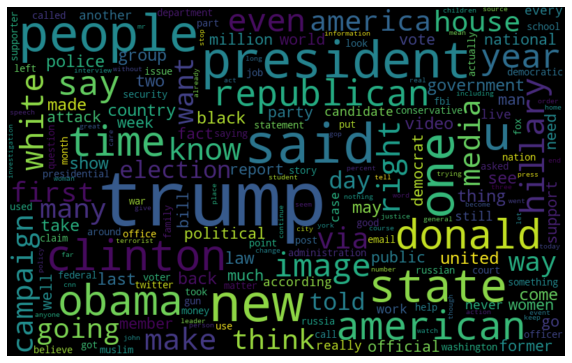

In [18]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

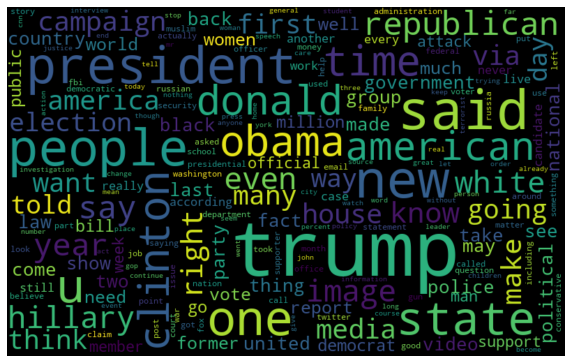

In [19]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [20]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Peparing the data

In [21]:
# Split the data
x_train,x_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)


Logistic regression

In [22]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(x_train, y_train)

# Accuracy
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.89%


Confusion matrix, without normalization


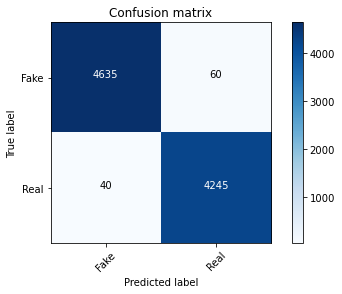

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Decision Tree Classifier

In [25]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(x_train, y_train)

# Accuracy
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.63%


Confusion matrix, without normalization


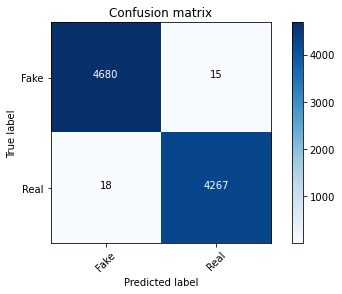

In [26]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))


accuracy: 99.05%


Confusion matrix, without normalization


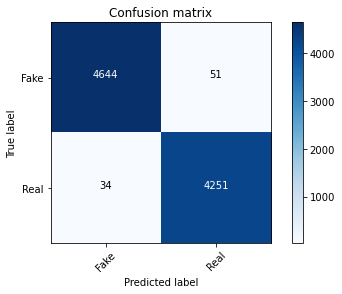

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

